# Tracking and Detection in Computer Vision Exercise 3

Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
#import tensorflow as tf
#import cv2
import os
import random

import props

In [15]:
%matplotlib inline
random.seed()

In [3]:
print(props.DATA_ROOT)
print(props.DATA_PREP)

C:/Users/thomala/Documents/TDCV-misc/ex3/dataset/
C:/Users/thomala/Documents/TDCV-misc/ex3/preprocessing/


# Task 1 Data Preparation

## Utility functions to load the data

In [4]:
def load_and_normalize_image(img_path):
    img = misc.imread(img_path)
    img_norm = (img - np.mean(img,axis=(0,1)))/np.std(img,axis=(0,1))
    return img_norm

In [5]:
def read_folder(folder_path, mask=[], direct=False):
    # gets the images in folder folder_path that are also in mask,
    # or if direct=False the images that are not in mask
    directory = os.fsencode(folder_path)
    image_files = []
    quaternions = []
    real_mask = []
    
    counter = 0
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        filepath = os.fsdecode(os.path.join(directory, file))
        if filename.endswith(".png"): 
            if (direct and counter in mask) or not (direct or counter in mask):
                image_files.append(load_and_normalize_image(filepath))
                real_mask.append(counter)
            counter += 1
        elif 'poses.txt' in filename:
            quaternions = [[float(s) for s in line.split()]\
                     for line in open(filepath).readlines()[1::2]]
    
    return image_files, [quaternions[i] for i in real_mask]    
    

### Testing the above functions

In [6]:
for i in range(1): # just to avoid creating useless global variables
    i1, q1 = read_folder(props.DATA_ROOT + 'coarse/ape/')
    i2, q2 = read_folder(props.DATA_ROOT + 'coarse/ape/', [2,3,5,7,9])
    i3, q3 = read_folder(props.DATA_ROOT + 'coarse/ape/', [2,3,5,7,9], True)
    print (len(i1))
    print (len(i2))
    print (len(i3))
    print (len(q1))
    print (len(q2))
    print (len(q3))
    print (q2[0])
    print (np.shape(i2[0]))
    #print(i2[0][::8,::8,:])

267
262
5
267
262
5
[-0.21679691686430014, -0.5855909685700639, 0.7631570083471646, -0.16635412522060855]
(64, 64, 3)


## Utility functions to visualize images

In [122]:
def to_visible(image):
    # puts image back in [0;1], so that we can visualize it
    mn = np.min(image)
    wd = np.max(image) - mn
    
    return (image - mn)/wd

def concatenate(images, indices):
    if len(np.shape(indices)) == 1:
        # concatenate samples from images with indices in 1D indices into one line
        res = to_visible(images[indices[0]])
        for index in indices[1:]:
            res = np.concatenate((res, to_visible(images[index])), axis=1)
        return res
    else:
        # reduce one dimension
        res = concatenate(images, indices[0])
        for index_array in indices[1:]:
            res = np.concatenate((res, concatenate(images, index_array)), axis=0)
        return res

def visualize(images, indices, save_path=""):
    fig = plt.figure()
    plt.imshow(concatenate(images, indices))
    plt.axis('off')
    if len(save_path) > 0:
        plt.savefig(save_path, pad_inches=0) # TODO there is still some white remaining in the result
    plt.show()

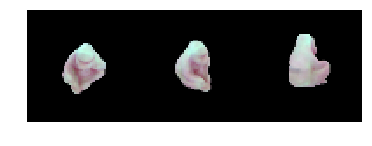

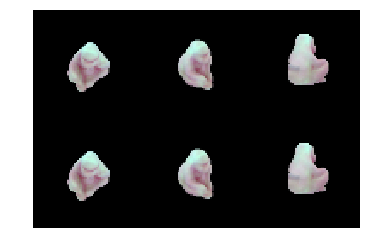

In [123]:
visualize(S_DB.images, [1,2,3])
visualize(S_DB.images, [[1,2,3],[1,2,3]], props.DATA_PREP + "test.png")

## Load the images and quaternions into datasets

_You need to read the images together with the poses (stored in quaternions) and construct 3 datasets:
the training set $S_{train}$ (train subset of the real folder and fine folder), test set $S_{test}$ (test
subset of the real folder) and database set $S_{db}$ ("coarse" folder)_

In [7]:
class Dataset:
    
    def __init__(self):
        self.images = []
        self.quats = []
    """ >> TODO make these work
    def add_image(img, quat, self):
        self.images.append(img)
        self.quats.append(quat)
    
    def get_image(i, self):
        img = self.images[i]
        quat = self.quats[i]
        return img, quat
    
    def add_data(imgs, quats, self):
        for img, quat in imgs, quats:
            self.add_image(img, quat)
    """

In [8]:

CLASSES = ['ape', 'benchvise', 'cam', 'cat', 'duck']

print("[WARNING] Remove real/duck/real1178-1252, we don't have their poses!")

S_TRAIN = Dataset()

S_TEST = Dataset()

S_DB = Dataset()

TRAIN_MASK = [int(s) for s in open(props.DATA_ROOT + 'real/training_split.txt')\
               .readlines()[0].split(',')]


[WARNING] Remove real/duck/real1178-1252, we don't have their poses!


In [9]:
for class_name in CLASSES:
    print(class_name)
    img_db, quat_db = read_folder(props.DATA_ROOT + 'coarse/' + class_name + '/')
    img_fn, quat_fn = read_folder(props.DATA_ROOT + 'fine/' + class_name + '/')
    img_tn, quat_tn = read_folder(props.DATA_ROOT + 'real/' + class_name + '/',
                                 TRAIN_MASK, True)
    img_ts, quat_ts = read_folder(props.DATA_ROOT + 'real/' + class_name + '/',
                                 TRAIN_MASK, False)
    
    
    for img in img_db:
        S_DB.images.append(img)
    for quat in quat_db:
        S_DB.quats.append(quat)
    for img in img_fn:
        S_TRAIN.images.append(img)
    for quat in quat_fn:
        S_TRAIN.quats.append(quat)
    for img in img_tn:
        S_TRAIN.images.append(img)
    for quat in quat_tn:
        S_TRAIN.quats.append(quat)
    for img in img_ts:
        S_TEST.images.append(img)
    for quat in quat_ts:
        S_TEST.quats.append(quat)
    
    

ape
benchvise
cam
cat
duck


### Check sizes of the datasets

Should be 2-by-2 equal, images contain $64 \times 64 \times 3$ arrays, quaternions contain 4 coordinates, and sizes be 1335 for DB, 7410 for TRAIN and 3535 for TEST

In [10]:
print (np.shape(S_DB.images))
print (np.shape(S_DB.quats))
print (np.shape(S_TRAIN.images))
print (np.shape(S_TRAIN.quats))
print (np.shape(S_TEST.images))
print (np.shape(S_TEST.quats))

(1335, 64, 64, 3)
(1335, 4)
(7410, 64, 64, 3)
(7410, 4)
(3535, 64, 64, 3)
(3535, 4)


## Batch generator

_The batch generator should be able to construct batches of triplets that are
later fed to the network. Each triplet consists of 3 samples: anchor, puller, and
pusher. Anchor is chosen randomly from the training set $S_{train}$. Puller is the most similar
(quaternion-wise) to anchor sample of the same object taken from the db set $S_{db}$. Finally, there are 2 types of pushers: it can either be the same object but a different
from puller pose or a randomly chosen different object. Pushers are also drawn from $S_{db}$_

### Create a random batch element following these requirements

Since quaterions in our case are of unit norm, their dot product is always in [0;1] in absolute value. Since arccos is strictly non-decreasing over [0;1], minimizing the quaternion angular metric $\theta(q_1, q_2) = 2 arccos(|q_1.q_2|)$ is strictly equivalent to maximizing their dot product, which is what we do to find the puller, for obvious speed reasons

In [33]:
def find_puller(quat):
    best_puller = 0
    best_result = 0
    for index in range(len(S_DB.quats)):
        current_result = abs(np.dot(quat, S_DB.quats[index]))
        if current_result > best_result:
            best_puller = index
            best_result = current_result
    return best_puller

In [34]:
# Sanity check :p
print(find_puller(S_DB.quats[3]))

3


In [35]:
def find_pusher(index, change_pose=0.5):
    nb_poses_per_object = len(S_DB.quats) // 5
    if (random.random() > change_pose): # TODO replace by the python for `rand()/randmax>change_pose`
        # then find another image with the same pose:
        # since all objects have the poses in the same order, this implies
        # looking for (index + R * N_DB / 5) % N_DB, where R is randomly
        # chosen in [1;4]
        R = random.randrange(1,5)
        return (index + R * nb_poses_per_object) % len(S_DB.quats)
    else:
        # then find another pose for the same image:
        # looking for a random number in index's interval [A,A+1]*N_DB/5
        # that isn't index, so basically (index + R) % N_DB/5 + A*N_DB/5
        # where R is randomly drawn in [1;N_DB/5]
        R = random.randrange(1,nb_poses_per_object)
        A = index // nb_poses_per_object
        return (index + R) % nb_poses_per_object + A * nb_poses_per_object

In [36]:
print("Number of poses per object:\t"+str(len(S_DB.quats) // 5))
print("Same pose, all objects are:", end='\t', flush=True)
for i in range(5):
    print(i * (len(S_DB.quats) // 5) + 325 % (len(S_DB.quats) // 5), end='\t', flush=True)
print("\nSame object, different poses are in:", end='\t', flush=True)
for i in range(1):
    N = len(S_DB.quats) // 5
    print(str((325 // N)*N) + "\t" + str((1 + 325 // N)*(N)) + "\nPusher examples:", end='\t', flush=True)
for i in range(100):
    print(find_pusher(325), end='\t', flush=True)

Number of poses per object:	267
Same pose, all objects are:	58	325	592	859	1126	
Same object, different poses are in:	267	534
Pusher examples:	526	58	447	1126	309	592	374	487	592	592	442	592	330	592	443	505	58	592	859	411	411	1126	58	296	381	859	513	505	430	859	384	1126	592	520	592	485	58	300	1126	342	274	1126	367	336	859	328	859	504	58	487	859	58	58	444	1126	592	859	488	520	475	58	294	366	475	859	381	307	404	359	859	377	58	1126	492	273	488	859	859	859	592	58	1126	592	393	592	369	299	358	592	360	592	859	859	399	592	859	1126	592	479	285	

In [37]:
def find_batch(change_pose=0.5):
    anchor = random.randrange(0, len(S_TRAIN.quats))
    puller = find_puller(S_TRAIN.quats[anchor])
    pusher = find_pusher(puller, change_pose)
    return anchor, puller, pusher

In [41]:
for i in range(20):
    print(find_batch(), end="   ", flush=True)

(5514, 35, 46)   (144, 48, 582)   (3374, 28, 562)   (5645, 237, 1038)   (6869, 254, 250)   (4331, 46, 847)   (6732, 226, 1027)   (6665, 200, 198)   (2798, 4, 141)   (864, 159, 29)   (4142, 228, 220)   (5213, 221, 488)   (2167, 199, 466)   (3740, 221, 488)   (1307, 148, 221)   (5259, 229, 146)   (37, 7, 170)   (2592, 229, 496)   (1356, 141, 942)   (5493, 111, 1179)   

## Generate the batch proper

In [48]:
def generate_batch(batch_size, change_pose=0.5):
    return [find_batch(change_pose) for i in range(batch_size)]

In [49]:
print(generate_batch(5))

[(5260, 225, 254), (3388, 119, 149), (833, 235, 1036), (5682, 189, 104), (3648, 198, 131)]


## Visualize the batch - TODO

Jieneng's code

In [14]:
class load_img:

    ## load image of one class from one of three folder(coarse, fine, real)
    ## the size of outputdata is (1178, 12292) containing 4 poses data and flatted normalized images data.
    def __init__(self, folderName, className, endIdx):
        imglist = []
        # 64*64*3 = 12288
        img_fla = []
        for i in range(0, endIdx + 1):
            i1 = str(i)
            imgpath = folderName + className + i1 + ".png"

            img = misc.imread(imgpath)
            imglist.append(img)

            f_img = np.ndarray.flatten(img)
            img_fla.append(f_img)

        '''Normalize RGB channel to zero mean and unit variable'''
        X = img_fla
        X = np.double(X)
        X -= np.mean(X, axis=0)
        X /= np.std(X, axis=0)
        nor_img = X

        '''Load the poses.txt data and convert them to a 2D list'''
        pos_path = folderName + "poses.txt"
        pos_dat = open(pos_path, 'r')
        a = pos_dat.read()
        pos_dat = a.split()
        ## the first 2 cols are # and "reali.png", which should be removed
        pos_dat = np.reshape(pos_dat, (endIdx + 1, 6))
        pos_dat = [[item for index, item in enumerate(items) if index != 0] for items in pos_dat]
        pos_dat = [[item for index, item in enumerate(items) if index != 0] for items in pos_dat]

        load_img.pos_list = []
        for i in range(endIdx + 1):
            a = list(map(float, pos_dat[i]))
            load_img.pos_list.append(a)

        load_img.data = []
        nor_img = nor_img.tolist()
        for i in range(endIdx + 1):
            b = load_img.pos_list[i]
            a = nor_img[i]
            b.extend(a)
            load_img.data.append(b)
        print("the column of load_img.pos_list should be 4 instead of 12292, do you know why when I give the value of load_img.pos_list to b, and it will be changed as b change?")
        print(np.shape(load_img.pos_list))

    def loa_img(self):
        dat = load_img.data
        return dat

    def loa_pos(self):
        pos_list = load_img.pos_list
        return pos_list


    def tra_img(self):
        spl_path = "/home/chen/exercise3/dataset/real/training_split.txt"
        spl_indice = open(spl_path, 'r')
        a = spl_indice.read()
        b = a.split(",")
        ind_list = list(map(int, b))
        # len = len(ind_list)
        tra_img = []
        for i in ind_list:
            tra = load_img.data[i]
            tra_img.append(tra)
        return tra_img

    def tra_pos(self):
        spl_path = "/home/chen/exercise3/dataset/real/training_split.txt"
        spl_indice = open(spl_path, 'r')
        a = spl_indice.read()
        b = a.split(",")
        ind_list = list(map(int, b))
        # len = len(ind_list)
        tra_pos = []
        for i in ind_list:
            tra = load_img.pos_list[i]
            tra_pos.append(tra)
        return tra_pos

    def tes_img(self):
        spl_path = "/home/chen/exercise3/dataset/real/training_split.txt"
        spl_indice = open(spl_path, 'r')
        a = spl_indice.read()
        b = a.split(",")
        ind_list = list(map(int, b))
        tes_img = []
        for i in range(1178):
            tes = load_img.data[i]
            for j in ind_list:
                if (i != j):
                    tes_img.append(tes)
        return tes_img



## should I use dictionary?
'''the shape of coa_ape(example) should be 266*12292'''
coa_ape = load_img("/home/chen/exercise3/dataset/coarse/ape/", "coarse", 266)
coa_ben = load_img("/home/chen/exercise3/dataset/coarse/benchvise/", "coarse", 266)
coa_cam = load_img("/home/chen/exercise3/dataset/coarse/cam/", "coarse", 266)
coa_cat = load_img("/home/chen/exercise3/dataset/coarse/cat/", "coarse", 266)
coa_duc = load_img("/home/chen/exercise3/dataset/coarse/duck/", "coarse", 266)

'''5*267*12292'''
S_db = []
S_db.extend(coa_ape.loa_img())
S_db.extend(coa_ben.loa_img())
S_db.extend(coa_cam.loa_img())
S_db.extend(coa_cat.loa_img())
S_db.extend(coa_duc.loa_img())
print("the shape of S_db:")
print(np.shape(S_db))

S_db_pos = []
S_db_pos.extend(coa_ape.loa_pos())
S_db_pos.extend(coa_ben.loa_pos())
S_db_pos.extend(coa_cam.loa_pos())
S_db_pos.extend(coa_cat.loa_pos())
S_db_pos.extend(coa_duc.loa_pos())
print("the shape of S_db_pos:")
print(np.shape(S_db_pos))

fin_ape = load_img("/home/chen/exercise3/dataset/fine/ape/", "fine", 1010)
fin_ben = load_img("/home/chen/exercise3/dataset/fine/benchvise/", "fine", 1010)
fin_cam = load_img("/home/chen/exercise3/dataset/fine/cam/", "fine", 1010)
fin_cat = load_img("/home/chen/exercise3/dataset/fine/cat/", "fine", 1010)
fin_duc = load_img("/home/chen/exercise3/dataset/fine/duck/", "fine", 1010)


print(np.shape(fin_ape.loa_img()))

rea_ape = load_img("/home/chen/exercise3/dataset/real/ape/", "real", 1177)
rea_ben = load_img("/home/chen/exercise3/dataset/real/benchvise/", "real", 1177)
rea_cam = load_img("/home/chen/exercise3/dataset/real/cam/", "real", 1177)
rea_cat = load_img("/home/chen/exercise3/dataset/real/cat/", "real", 1177)
rea_duc = load_img("/home/chen/exercise3/dataset/real/duck/", "real", 1177)








#
# S_tra = []
# tra_ape = rea_ape.tra_img()
# tra_ben = rea_ape.tra_img()
# tra_cam = rea_ape.tra_img()
# tra_cat = rea_ape.tra_img()
# tra_duc = rea_ape.tra_img()

# S_tra.append(fin_ape.loa_img())
# S_tra.append(tra_ape)
# S_tra.append(fin_ben.loa_img())
# S_tra.append(tra_ben)
# S_tra.append(fin_cam.loa_img())
# S_tra.append(tra_cam)
# S_tra.append(fin_cat.loa_img())
# S_tra.append(tra_cat)
# S_tra.append(fin_duc.loa_img())
# S_tra.append(tra_duc)
#
# S_tra_pos= []
# tra_ape = rea_ape.tra_pos()
# tra_ben = rea_ben.tra_pos()
# tra_cam = rea_cam.tra_pos()
# tra_cat = rea_cat.tra_pos()
# tra_duc = rea_duc.tra_pos()
#
# S_tra.append(fin_ape.loa_pos())
# S_tra.append(tra_ape)
# S_tra.append(fin_ben.loa_pos())
# S_tra.append(tra_ben)
# S_tra.append(fin_cam.loa_pos())
# S_tra.append(tra_cam)
# S_tra.append(fin_cat.loa_pos())
# S_tra.append(tra_cat)
# S_tra.append(fin_duc.loa_pos())
# S_tra.append(tra_duc)

#print(np.shape(S_tra))

S_tes = []
S_tes.append(rea_ape)
S_tes.append(rea_ben)
S_tes.append(rea_cam)
S_tes.append(rea_cat)
S_tes.append(rea_duc)
tes_ape = rea_ape.tes_img()
tes_ben = rea_ape.tes_img()
tes_cam = rea_ape.tes_img()
tes_cat = rea_ape.tes_img()
tes_duc = rea_ape.tes_img()
S_tes.append(tes_ape)
S_tes.append(tes_ben)
S_tes.append(tes_cam)
S_tes.append(tes_cat)
S_tes.append(tes_duc)



#n = np.shape(S_tra)
#print(n)
#print(np.shape(tra_duc))


'''input the pos_list containing only  quaternion poses of S_db'''
'''output is a 2D list, each row contain a indice of a pose from'''
'''S_db and a indice of another similar pose to find puller'''
def similarity(S_db_pos, S_tra_pos):
    #In the data set of S_db, find the one which is most similar to the other one
    theta = []
    sim_ind = [[]]
    for i in len(S_db_pos):
        for j in len(S_tra_pos):
            theta[i] = np.arccos(abs(S_db_pos[i] * S_tra_pos[j]))
            if(theta[i] < a):
                a = theta[i]
                sim_ind[i] = i
                sim_ind[i].append(j)
    return sim_ind


'''need to create a 3D list to put the batches in??'''
def batch_generator(S_db, S_tra, n):

    len_db = len(S_db)
    len_tra = len(S_tra)
    gen_ind_tra = np.arrange(len_tra)
    gen_ind_tra = np.random.shuffle(gen_ind_tra)
    gen_ind_tra = gen_ind_tra[0:n]

    sim_ind = similarity(S_db_pos, S_tra_pos)

    batch = []
    for i in gen_ind_tra:
        anchor = S_tra[i]
        ##first dimension is anchor from S_tra, second is puller from S_db
        batch.append(anchor)
        puller = S_db[(sim_ind[i][1])]
        batch.append(puller)
        ##there are 2 types of pushers: it can either be the same object but a different
        ## from puller pose or a randomly chosen different object from S_db
        '''hypothesis that the shape of S_db is 5*267*12292'''
        gen_ind_db_cla = np.random.randint(5)
        gen_ind_db = np.random.shuffle(gen_ind_db_cla)
        if(S_db[gen_ind_db_cla][gen_ind_db] != puller):
            pusher = S_db[gen_ind_db_cla][gen_ind_db]
        batch.append(pusher)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\thomala\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-60c355c19c69>", line 104, in <module>
    coa_ape = load_img("/home/chen/exercise3/dataset/coarse/ape/", "coarse", 266)
  File "<ipython-input-14-60c355c19c69>", line 13, in __init__
    img = misc.imread(imgpath)
  File "C:\Users\thomala\Anaconda3\lib\site-packages\scipy\misc\pilutil.py", line 156, in imread
    im = Image.open(name)
  File "C:\Users\thomala\Anaconda3\lib\site-packages\PIL\Image.py", line 2477, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/chen/exercise3/dataset/coarse/ape/coarse0.png'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\thomala\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 180

FileNotFoundError: [Errno 2] No such file or directory: '/home/chen/exercise3/dataset/coarse/ape/coarse0.png'